In [79]:
import sys
import sympy as sp
import math
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

(-5.0, 5.0)

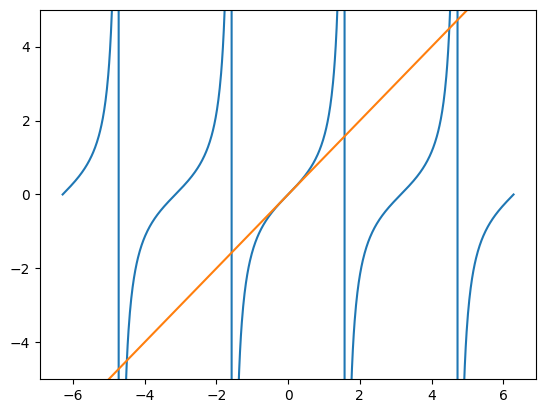

In [80]:
eps = 10e-5;
x = sp.symbols("x", real=True)
z = sp.symbols("z", complex=True)
task = lambda x: sp.tan(x) - x
z_task = lambda z: z**3 - complex(1, 0)

Ox = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
plt.plot(Ox, np.tan(Ox))
plt.plot(Ox, Ox)
plt.ylim(-5, 5)

In [81]:
def get_tan_interval(n):
    return [(-np.pi / 2) + (n * np.pi) + eps, (np.pi / 2) + (n * np.pi) - eps]

In [82]:
# Requirements:
#  f(x) is a monotonic and continuous function on the given interval.
#  At the endpoints of the interval, the values of f(x) have opposite signs.


def dichotomy_method(expression, interval, epsilon=eps):
    a = np.float64(interval[0])
    b = np.float64(interval[1])

    if expression(a) * expression(b) >= 0:
        print("Wrong interval!")
        return None

    c = a
    iterations = 0
    while (b - a) / 2 > epsilon:
        c = (a + b) / 2
        iterations += 1
        if expression(c) == 0.0:
            break
        elif expression(c) * expression(b) < 0:
            a = c
        else:
            b = c

    return c, iterations

In [83]:
dichotomy_method(task, get_tan_interval(-2))

(-7.725227186308543, 14)

In [84]:
def get_new_interval(expression, old_interval, accuracy):
    step = (old_interval[1] - old_interval[0]) / accuracy
    interval = list()
    _from = old_interval[0]
    _to = old_interval[0] + step
    while _to <= old_interval[1]:
        interval.append(_from)
        _from += step
        _to += step

    func_interval = [expression(i) for i in interval]
    
    index = min(enumerate(func_interval), key = lambda x: abs(x[1]))[0]
    if index == 0:
        first_bound = interval[index]
        second_bound = interval[index + 1]
    elif index == len(func_interval) - 1:
        first_bound = interval[index - 1]
        second_bound = interval[index]
    else:
        if func_interval[index + 1] > func_interval[index - 1]:
            first_bound = interval[index - 1]
            second_bound = interval[index]
        else:
            first_bound = interval[index]
            second_bound = interval[index + 1]

    return first_bound, second_bound

In [85]:
# Requirements:
#  The modulus of the first derivative is less than one near zero.
#  Gets f(x) from equation f(x) = x.

# это только для сжимающих отображений - Fixed

def simple_iteration_method(expression, interval, epsilon=eps):
    a = np.float64(interval[0])
    b = np.float64(interval[1])

    a, b = get_new_interval(expression, [a, b], 500)
    df_symb = sp.diff(expression(x))
    df = sp.lambdify(x, df_symb)


    x0 = 0
    if df(a) < 1:
        x0 = a
    elif df(b) < 1:
        x0 = b
    else:
        print(df(a), df(b))
        print("Wrong interval!")
        return None
    
    lambda0 = df(x0)
    xn = x0
    iterations = 0

    while True:
        iterations += 1
        
        xn -= expression(xn) * lambda0
        x0 = xn
        
        if abs(xn - x0) < epsilon:
            break
        

    return xn, iterations

In [86]:
simple_iteration_method(lambda x: sp.tan(x) - x, get_tan_interval(0))

(-0.00628278530391000, 1)

In [87]:
def newton_method(expression, interval, epsilon=eps, dtype=np.float64):
    a = dtype(interval[0])
    b = dtype(interval[1])

    a, b = get_new_interval(expression, [a, b], 200)
    df_symb = sp.diff(expression(x))
    df = sp.lambdify(x, df_symb)
    
    d2f_symb = sp.diff(df_symb, x)
    d2f = sp.lambdify(x, d2f_symb)

    x0 = b
    xn = x0
    iterations = 0

    while True:
        iterations += 1
        
        if abs(expression(dtype(xn)) * d2f(dtype(xn))) >= df(dtype(xn)) ** 2:
            print("Wrong in")
            return None
        
        x0 = xn
        xn = dtype(x0) - expression(dtype(x0)) / df(dtype(x0))
        
        if abs(xn - x0) < epsilon:
            break
        

    return xn, iterations


In [88]:
newton_method(task, get_tan_interval(0))

(-6.38378239159465e-16, 1)

In [89]:
# поменять критерий остановки - Fixed


def secant_method(expression, interval, epsilon=0.01, dtype=np.float64):
    a = dtype(interval[0])
    b = dtype(interval[1])

    a, b = get_new_interval(expression, [a, b], 20)

    x0 = b
    xn = a
    difference = 0
    iterations = 0
    max_iterations = 1000

    for iterations in range(max_iterations):

        old_x = xn
        xn = dtype(xn) - expression(x0) * (
            (dtype(xn) - dtype(x0)) / (expression(dtype(xn)) - expression(dtype(x0)))
        )
        x0 = old_x

        if abs(xn - x0) < epsilon:
            difference = abs(xn - x0)
            while difference - abs(xn - x0) >= 0:
                iterations += 1
                difference = abs(xn - x0)

                old_x = xn
                xn = dtype(xn) - expression(dtype(x0)) * (
                    (dtype(xn) - dtype(x0))
                    / (expression(dtype(xn)) - expression(dtype(x0)))
                )
                x0 = old_x

            return xn, iterations

    print("To many iterations!")
    return None

In [90]:
secant_method(task, get_tan_interval(1))

(4.79095900559910, 3)

In [91]:
particular_point = np.complex128(0.6 + -0.15j)
convergent_roots = [particular_point]

def complex_newton_method(expression, interval, epsilon=sys.float_info.epsilon, dtype=np.complex128, z0=0):
    a = np.float64(interval[0])
    b = np.float64(interval[1])

    a, b = get_new_interval(expression, [a, b], 20)
    df_symb = sp.diff(expression(z))
    df = sp.lambdify(z, df_symb)
    
    path_point_convergence_flag = False
    
    x0 = z0
    num_to_round = 4

    round_x0 = np.complex128(
        round(x0.real, num_to_round) + round(x0.imag, num_to_round)*1j)
    round_convergent_point = np.complex128([round(
        particular_point.real, num_to_round) + round(particular_point.imag, num_to_round)*1j])

    if round_x0 == round_convergent_point:
        path_point_convergence_flag = True

    iterations = 0
    
    while True:
        iterations += 1
        
        xn = dtype(x0) - expression(dtype(x0)) / df(dtype(x0))
        
        if path_point_convergence_flag:
            convergent_roots.append(dtype(xn))
            
        if abs(xn - x0) < epsilon:
            break
        
        x0 = xn
        
    return xn, iterations

In [92]:
x_range = np.arange(-1, 1, 0.1)
y_range = np.arange(-1, 1, 0.1)
X, Y = np.meshgrid(x_range, y_range)
Z = X + 1j * Y

roots = np.zeros(Z.shape, dtype=np.complex128)

for (x, y), _ in np.ndenumerate(Z):
    z0 = Z[x, y]
    root, _ = complex_newton_method(z_task, get_tan_interval(0), z0=z0)
    roots[x, y] = root

Roots:  [(0.6-0.15j)]


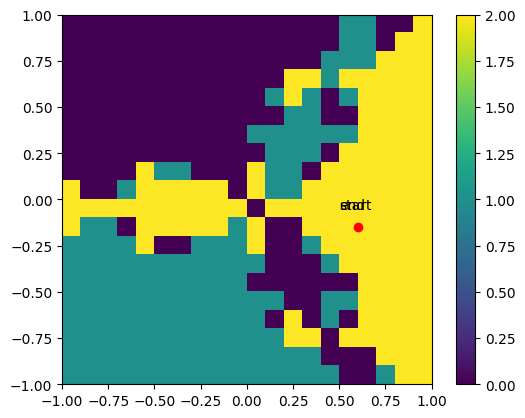

In [93]:
path_real = np.array([])
path_imag = np.array([])

print("Roots: ", convergent_roots)
path_real = np.array([i.real for i in convergent_roots])
path_imag = np.array([i.imag for i in convergent_roots])


unique_roots = np.unique(roots.round(decimals=8))
root_colors = {root: i for i, root in enumerate(unique_roots)}
colors = np.vectorize(root_colors.get)(roots.round(decimals=8))

plt.imshow(colors, extent=[-1, 1, -1, 1])
plt.colorbar()

plt.annotate('start', xy=(path_real[0], path_imag[0]), xytext=(
    path_real[0]-0.1, path_imag[0]+0.1))
plt.annotate('end', xy=(
    path_real[-1], path_imag[-1]), xytext=(path_real[-1]-0.1, path_imag[-1]+0.1))

plt.plot(path_real, path_imag, color="red", marker='o', linewidth=2)
plt.show()

Result for 0,004**2 accuracy

![image.png](Task2.result.png)